
# Cab Investment – G2M Strategy

#### Jason Robinson   

August 7th, 2022

**XYZ** in implementing its Go-to-market strategy we will examine specific features and their relationships to determine if investment would be profitable. Accompanying methods will incorporate statistical analysis to measure principal features and outcomes.


# EDA

To be able to give the best recommendations we need to understand the data thouroughly inside and out to see any direct or indirect correlations.


In [1]:
# Basic Libraries
import os
import sys
import pandas as pd
import numpy as np

# Time Series 
import statsmodels
import statsmodels.api as sm
from statsmodels.tsa import stattools as ts
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima_model import ARIMAResults

# Scientific
import scipy

# Matplotlib
import matplotlib
import matplotlib.pyplot as plt
from pylab import rcParams
plt.style.use('fivethirtyeight')
%matplotlib inline

# Visualizations
import plotly
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
from plotly import tools
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.figure_factory as ff

# Function to display plotly in jupyter notebook
def enable_plotly_in_cell():
    import IPython
    from plotly.offline import init_notebook_mode
    display(IPython.core.display.HTML('''<script src="/static/components/requirejs/require.js"></script>'''))
    init_notebook_mode(connected=False)


print('Matplotlib:',matplotlib.__version__)
print('Pandas:',pd.__version__)
print('Numpy:',np.__version__)
print('StatsModel:',statsmodels.__version__)
print('Scipy:',scipy.__version__)

Matplotlib: 3.5.1
Pandas: 1.3.5
Numpy: 1.21.5
StatsModel: 0.13.2
Scipy: 1.7.3


In [2]:
# Import the data by reeading multiple files
city = pd.read_csv('/Users/jasonrobinson/Desktop/cab_dataset/City.csv')
cab = pd.read_csv('/Users/jasonrobinson/Desktop/cab_dataset/Cab_Data.csv')
customer = pd.read_csv('/Users/jasonrobinson/Desktop/cab_dataset/Customer_ID.csv')
transaction = pd.read_csv('/Users/jasonrobinson/Desktop/cab_dataset/Transaction_ID.csv')


In [3]:
print('City:',city.shape)
print('Cab:',cab.shape)
print('Customer:',customer.shape)
print('Transaction:',transaction.shape)

City: (20, 3)
Cab: (359392, 7)
Customer: (49171, 4)
Transaction: (440098, 3)


We will merge our datasets according to their primary keys. For this instance we are performing a left join on transaction id and a right join on customer id.

In [4]:
# Merge the datasets on primary keys
cab_data = cab.merge(transaction, on='Transaction ID').merge(customer, on='Customer ID')
print(cab_data.shape)
cab_data.sample(5)

(359392, 12)


,Transaction ID,Date of Travel,Company,City,KM Travelled,Price Charged,Cost of Trip,Customer ID,Payment_Mode,Gender,Age,Income (USD/Month)
203896,10229012,43004,Yellow Cab,WASHINGTON DC,21.00,296.87,252.0000,51138,Cash,Female,25,17458
112540,10286523,43093,Yellow Cab,NEW YORK NY,22.80,583.57,300.9600,1598,Card,Male,24,11774
111275,10036104,42518,Pink Cab,LOS ANGELES CA,11.70,124.97,122.8500,6510,Card,Male,19,6921
259823,10150171,42800,Yellow Cab,CHICAGO IL,32.77,454.81,460.0908,4936,Card,Female,32,15612
136793,10012670,42435,Pink Cab,LOS ANGELES CA,4.80,72.88,49.4400,8175,Card,Male,24,12571


In [5]:
cab_data.info();

<class 'pandas.core.frame.DataFrame'>
Int64Index: 359392 entries, 0 to 359391
Data columns (total 12 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   Transaction ID      359392 non-null  int64  
 1   Date of Travel      359392 non-null  int64  
 2   Company             359392 non-null  object 
 3   City                359392 non-null  object 
 4   KM Travelled        359392 non-null  float64
 5   Price Charged       359392 non-null  float64
 6   Cost of Trip        359392 non-null  float64
 7   Customer ID         359392 non-null  int64  
 8   Payment_Mode        359392 non-null  object 
 9   Gender              359392 non-null  object 
 10  Age                 359392 non-null  int64  
 11  Income (USD/Month)  359392 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 35.6+ MB


In [6]:
# Check for nan values in each dataset
def check_nan(cab_data):
    print(cab_data.isnull().sum()/len(cab_data)*100,'%','\n')
    return cab_data

check_nan(cab_data)

Transaction ID        0.0
Date of Travel        0.0
Company               0.0
City                  0.0
KM Travelled          0.0
Price Charged         0.0
Cost of Trip          0.0
Customer ID           0.0
Payment_Mode          0.0
Gender                0.0
Age                   0.0
Income (USD/Month)    0.0
dtype: float64 % 



,Transaction ID,Date of Travel,Company,City,KM Travelled,Price Charged,Cost of Trip,Customer ID,Payment_Mode,Gender,Age,Income (USD/Month)
0,10000011,42377,Pink Cab,ATLANTA GA,30.45,370.95,313.6350,29290,Card,Male,28,10813
1,10351127,43302,Yellow Cab,ATLANTA GA,26.19,598.70,317.4228,29290,Cash,Male,28,10813
2,10412921,43427,Yellow Cab,ATLANTA GA,42.55,792.05,597.4020,29290,Card,Male,28,10813
3,10000012,42375,Pink Cab,ATLANTA GA,28.62,358.52,334.8540,27703,Card,Male,27,9237
4,10320494,43211,Yellow Cab,ATLANTA GA,36.38,721.10,467.1192,27703,Card,Male,27,9237
...,...,...,...,...,...,...,...,...,...,...,...,...
359387,10439790,43107,Yellow Cab,SEATTLE WA,16.66,261.18,213.9144,38520,Card,Female,42,19417
359388,10439799,43103,Yellow Cab,SILICON VALLEY,13.72,277.97,172.8720,12490,Cash,Male,33,18713
359389,10439838,43104,Yellow Cab,TUCSON AZ,19.00,303.77,232.5600,41414,Card,Male,38,3960
359390,10439840,43106,Yellow Cab,TUCSON AZ,5.60,92.42,70.5600,41677,Cash,Male,23,19454


In [7]:
# Iterate through each dataset and format header to lowercase and join with ('_')
def format_header(cab_data):
    cab_data.columns = [x.lower().replace(' ', '_') for x in cab_data.columns]
    cab_data.rename(columns={'cost_of_trip':'trip_cost', 
                            'income_(usd/month)':'monthly_income',
                             'transaction_id':'transact_id'}, inplace=True)
    return cab_data    


cab_data = format_header(cab_data)
cab_data.head(2)

,transact_id,date_of_travel,company,city,km_travelled,price_charged,trip_cost,customer_id,payment_mode,gender,age,monthly_income
0,10000011,42377,Pink Cab,ATLANTA GA,30.45,370.95,313.6350,29290,Card,Male,28,10813
1,10351127,43302,Yellow Cab,ATLANTA GA,26.19,598.70,317.4228,29290,Cash,Male,28,10813


***
Start Date Refactor

In [8]:
# Convert date of travel string into datetime providing our 
# timestep function for begin

begin = pd.Timestamp('1900-1-28')

cab_data["travel_date"] = pd.to_datetime(cab_data["date_of_travel"], unit="D", origin=begin)
cab_data = cab_data.drop('date_of_travel', axis=1)

cab_data.head()

,transact_id,company,city,km_travelled,price_charged,trip_cost,customer_id,payment_mode,gender,age,monthly_income,travel_date
0,10000011,Pink Cab,ATLANTA GA,30.45,370.95,313.6350,29290,Card,Male,28,10813,2016-02-06
1,10351127,Yellow Cab,ATLANTA GA,26.19,598.70,317.4228,29290,Cash,Male,28,10813,2018-08-19
2,10412921,Yellow Cab,ATLANTA GA,42.55,792.05,597.4020,29290,Card,Male,28,10813,2018-12-22
3,10000012,Pink Cab,ATLANTA GA,28.62,358.52,334.8540,27703,Card,Male,27,9237,2016-02-04
4,10320494,Yellow Cab,ATLANTA GA,36.38,721.10,467.1192,27703,Card,Male,27,9237,2018-05-20


In [9]:

cab_data = cab_data[cab_data['travel_date'] < '2019-1-1']
cab_data['travel_date'].sort_values()

823      2016-01-31
1830     2016-01-31
9863     2016-01-31
17572    2016-01-31
2025     2016-01-31
            ...    
300047   2018-12-31
66172    2018-12-31
201295   2018-12-31
309559   2018-12-31
8335     2018-12-31
Name: travel_date, Length: 344953, dtype: datetime64[ns]

In [10]:
cab_data['travel_date'] = pd.to_datetime(cab_data['travel_date'])
cab_data = cab_data.set_index('travel_date')
cab_data.index

DatetimeIndex(['2016-02-06', '2018-08-19', '2018-12-22', '2016-02-04',
               '2018-05-20', '2018-06-02', '2018-11-25', '2016-01-31',
               '2016-10-20', '2017-07-22',
               ...
               '2018-02-01', '2018-02-02', '2018-02-01', '2018-01-30',
               '2018-02-01', '2018-02-05', '2018-02-01', '2018-02-02',
               '2018-02-04', '2018-02-02'],
              dtype='datetime64[ns]', name='travel_date', length=344953, freq=None)

In [11]:
cab_data.index

DatetimeIndex(['2016-02-06', '2018-08-19', '2018-12-22', '2016-02-04',
               '2018-05-20', '2018-06-02', '2018-11-25', '2016-01-31',
               '2016-10-20', '2017-07-22',
               ...
               '2018-02-01', '2018-02-02', '2018-02-01', '2018-01-30',
               '2018-02-01', '2018-02-05', '2018-02-01', '2018-02-02',
               '2018-02-04', '2018-02-02'],
              dtype='datetime64[ns]', name='travel_date', length=344953, freq=None)

In [12]:
# Filter to 31/01/2016 to 31/12/2018
cab_column = cab_data[cab_data.index < '2019-01-01']
cab_column.index.sort_values()

DatetimeIndex(['2016-01-31', '2016-01-31', '2016-01-31', '2016-01-31',
               '2016-01-31', '2016-01-31', '2016-01-31', '2016-01-31',
               '2016-01-31', '2016-01-31',
               ...
               '2018-12-31', '2018-12-31', '2018-12-31', '2018-12-31',
               '2018-12-31', '2018-12-31', '2018-12-31', '2018-12-31',
               '2018-12-31', '2018-12-31'],
              dtype='datetime64[ns]', name='travel_date', length=344953, freq=None)

***
End Date Refactor

In [13]:
# Make a copy
cab_data = cab_data.copy()

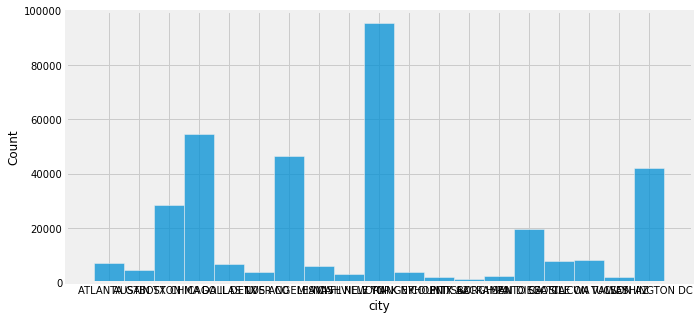

In [14]:
# Display a distribution City in cab data
fig, ax = plt.subplots(figsize=(10,5))
sns.histplot(cab_data['city'],
             palette='Set1',
             ax=ax)
plt.show()

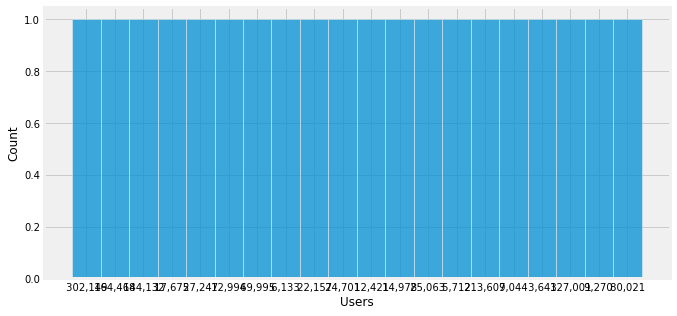

In [15]:
# Display a distribution hist for users in city
fig, ax = plt.subplots(figsize=(10,5))
sns.histplot(city['Users'],
            palette='Set3',
            ax=ax)
plt.show()

A clear pattern of seasonality, with annual highs consistently for the time range, which helps us better predict future activity.

### Summary Statistics

In [16]:
# Display the min, max, mean, and median of each numeric column
def min_max_mean_median(cab_data):
    print(f'Min, Max, Mean, Median for the {cab_data.company} Company:')
    print(cab_data.describe())
    return cab_data

min_max_mean_median(cab_data)

Min, Max, Mean, Median for the travel_date
2016-02-06      Pink Cab
2018-08-19    Yellow Cab
2018-12-22    Yellow Cab
2016-02-04      Pink Cab
2018-05-20    Yellow Cab
                 ...    
2018-02-05    Yellow Cab
2018-02-01    Yellow Cab
2018-02-02    Yellow Cab
2018-02-04    Yellow Cab
2018-02-02    Yellow Cab
Name: company, Length: 344953, dtype: object Company:
        transact_id   km_travelled  price_charged      trip_cost  \
count  3.449530e+05  344953.000000  344953.000000  344953.000000   
mean   1.021209e+07      22.569888     424.202059     286.234017   
std    1.219786e+05      12.232695     275.189521     157.979823   
min    1.000001e+07       1.900000      15.600000      19.000000   
25%    1.010658e+07      12.000000     206.790000     151.257600   
50%    1.021270e+07      22.440000     386.810000     282.492000   
75%    1.031707e+07      32.960000     584.740000     413.751000   
max    1.044011e+07      48.000000    2048.030000     691.200000   

         custom

,transact_id,company,city,km_travelled,price_charged,trip_cost,customer_id,payment_mode,gender,age,monthly_income
travel_date,,,,,,,,,,,
2016-02-06,10000011,Pink Cab,ATLANTA GA,30.45,370.95,313.6350,29290,Card,Male,28,10813
2018-08-19,10351127,Yellow Cab,ATLANTA GA,26.19,598.70,317.4228,29290,Cash,Male,28,10813
2018-12-22,10412921,Yellow Cab,ATLANTA GA,42.55,792.05,597.4020,29290,Card,Male,28,10813
2016-02-04,10000012,Pink Cab,ATLANTA GA,28.62,358.52,334.8540,27703,Card,Male,27,9237
2018-05-20,10320494,Yellow Cab,ATLANTA GA,36.38,721.10,467.1192,27703,Card,Male,27,9237
...,...,...,...,...,...,...,...,...,...,...,...
2018-02-05,10439790,Yellow Cab,SEATTLE WA,16.66,261.18,213.9144,38520,Card,Female,42,19417
2018-02-01,10439799,Yellow Cab,SILICON VALLEY,13.72,277.97,172.8720,12490,Cash,Male,33,18713
2018-02-02,10439838,Yellow Cab,TUCSON AZ,19.00,303.77,232.5600,41414,Card,Male,38,3960


#### AGE

In [17]:
print(f'Mean Age:-----------------------',cab_data.describe().at['mean','age'])
print(f'Standard Deviation Age:---------',cab_data.describe().at['std', 'age'])
print(f'Age within the (25th%):---------',cab_data.describe().at['25%', 'age'])
print(f'Age within the (50th%):---------',cab_data.describe().at['50%', 'age'])
print(f'Age within the (75th%):---------',cab_data.describe().at['75%', 'age'])

Mean Age:----------------------- 35.338364936672534
Standard Deviation Age:--------- 12.598427624774773
Age within the (25th%):--------- 25.0
Age within the (50th%):--------- 33.0
Age within the (75th%):--------- 42.0


#### Price Charged

In [18]:
print(f'Mean Price_Charged:-----------------------',cab_data.describe().at['mean','price_charged'])
print(f'Standard Deviation Price_Charged:---------',cab_data.describe().at['std', 'price_charged'])
print(f'Price_charged within the (25th%):---------',cab_data.describe().at['25%', 'price_charged'])
print(f'Price_charged within the (50th%):---------',cab_data.describe().at['50%', 'price_charged'])
print(f'Price_charged within the (75th%):---------',cab_data.describe().at['75%', 'price_charged'])

Mean Price_Charged:----------------------- 424.2020590341295
Standard Deviation Price_Charged:--------- 275.18952089115083
Price_charged within the (25th%):--------- 206.79
Price_charged within the (50th%):--------- 386.81
Price_charged within the (75th%):--------- 584.74


#### KM Travelled

In [19]:
print(f'Mean KM_Traveled:-----------------------',cab_data.describe().at['mean','km_travelled'])
print(f'Standard Deviation KM_Traveled:---------',cab_data.describe().at['std', 'km_travelled'])
print(f'KM_Traveled within the (25th%):---------',cab_data.describe().at['25%', 'km_travelled'])
print(f'KM_Traveled within the (50th%):---------',cab_data.describe().at['50%', 'km_travelled'])
print(f'KM_Traveled within the (75th%):---------',cab_data.describe().at['75%', 'km_travelled'])

Mean KM_Traveled:----------------------- 22.569887578887535
Standard Deviation KM_Traveled:--------- 12.232694674157667
KM_Traveled within the (25th%):--------- 12.0
KM_Traveled within the (50th%):--------- 22.44
KM_Traveled within the (75th%):--------- 32.96


#### Trip Cost

In [20]:
print(f'Mean Trip_Cost:-----------------------',cab_data.describe().at['mean','trip_cost'])
print(f'Standard Deviation Trip_Cost:---------',cab_data.describe().at['std', 'trip_cost'])
print(f'Trip_Cost within the (25th%):---------',cab_data.describe().at['25%', 'trip_cost'])
print(f'Trip_Cost within the (50th%):---------',cab_data.describe().at['50%', 'trip_cost'])
print(f'Trip_Cost within the (75th%):---------',cab_data.describe().at['75%', 'trip_cost'])

Mean Trip_Cost:----------------------- 286.23401725856434
Standard Deviation Trip_Cost:--------- 157.97982262822
Trip_Cost within the (25th%):--------- 151.2576
Trip_Cost within the (50th%):--------- 282.492
Trip_Cost within the (75th%):--------- 413.751


### Visualizations

Split dataset up by company for comparison of data between companies.

In [21]:
# Create a dataset for each company
cab_yellow = cab_data[cab_data['company'] == 'Yellow Cab']
cab_pink = cab_data[cab_data['company'] == 'Pink Cab']
print(f'Shape of the Yellow Cab Company:', cab_yellow.shape)
print(f'Shape of the Pink Cab Company:', cab_pink.shape)

Shape of the Yellow Cab Company: (263739, 11)
Shape of the Pink Cab Company: (81214, 11)


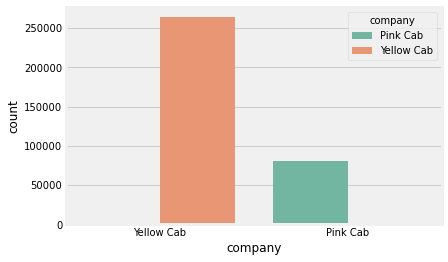

In [22]:
# Display a count pink and yellow cab companies in reference to transactions
sns.countplot(x='company', 
              data=cab_data, 
              palette='Set2', 
              order=['Yellow Cab', 'Pink Cab'],
              hue='company');

### Frequecy of Transactions

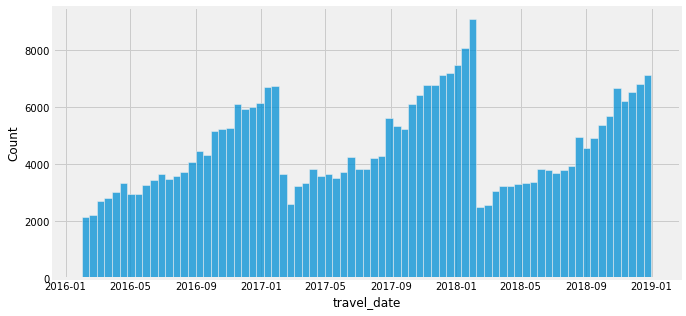

In [23]:
fig, ax = plt.subplots(figsize=(10,5))
sns.histplot(cab_data.index,
            palette='Set1',
            ax=ax)
plt.show()

Follow some of our questions for **both** companies:

1. How many transactions are there in the data?
2. What is the mean age of the users in the data?
3. What is the mean price charged for the transactions in the data?
4. What is the mean KM traveled for the transactions in the data?
5. What is the mean trip cost for the transactions in the data?

In [24]:
print(f'Number of transactions:', cab_data.shape[0])
print(f'Mean Age:--------------',cab_data.describe().at['mean','age'])
print(f'Mean Price_Charged:----',cab_data.describe().at['mean','price_charged'])
print(f'Mean KM_Traveled:------',cab_data.describe().at['mean','km_travelled'])
print(f'Mean Trip_Cost:--------',cab_data.describe().at['mean','trip_cost'])

Number of transactions: 344953
Mean Age:-------------- 35.338364936672534
Mean Price_Charged:---- 424.2020590341295
Mean KM_Traveled:------ 22.569887578887535
Mean Trip_Cost:-------- 286.23401725856434


Follow some of our questions for **each** company:

1. How many transactions are there in the data?
2. What is the mean age of the users in the data?
3. What is the mean price charged for the transactions in the data?
4. What is the mean KM traveled for the transactions in the data?
5. What is the mean trip cost for the transactions in the data?

In [25]:
print(f'Number of transactions:', cab_yellow.shape[0])
print(f'Mean Age:--------------',cab_yellow.describe().at['mean','age'])
print(f'Mean Price_Charged:----',cab_yellow.describe().at['mean','price_charged'])
print(f'Mean KM_Traveled:------',cab_yellow.describe().at['mean','km_travelled'])
print(f'Mean Trip_Cost:--------',cab_yellow.describe().at['mean','trip_cost'])

Number of transactions: 263739
Mean Age:-------------- 35.34186828644986
Mean Price_Charged:---- 459.2630340601972
Mean KM_Traveled:------ 22.57098654351449
Mean Trip_Cost:-------- 297.9429294279541


In [26]:
print(f'Number of transactions:', cab_pink.shape[0])
print(f'Mean Age:--------------',cab_pink.describe().at['mean','age'])
print(f'Mean Price_Charged:----',cab_pink.describe().at['mean','price_charged'])
print(f'Mean KM_Traveled:------',cab_pink.describe().at['mean','km_travelled'])
print(f'Mean Trip_Cost:--------',cab_pink.describe().at['mean','trip_cost'])

Number of transactions: 81214
Mean Age:-------------- 35.326987957741274
Mean Price_Charged:---- 310.3430385155252
Mean KM_Traveled:------ 22.566318738148407
Mean Trip_Cost:-------- 248.20982454995826


In [27]:
# Create a function to calculate the difference between the mean of the two companies
def mean_difference(cab_data):
    print(f'Mean Difference for Age:', cab_yellow.describe().at['mean','age'] - cab_pink.describe().at['mean','age'])
    return cab_data

In [28]:

# Print out the mean difference for each feature
print(f'Yellow Cab Mean Difference for Age:',cab_yellow.describe().at['mean','age'] - cab_pink.describe().at['mean','age'])
print(f'Yellow Cab Mean Difference for KM Travel:',cab_yellow.describe().at['mean','km_travelled'] - cab_pink.describe().at['mean','km_travelled'])
print(f'Yellow Cab Mean Difference for Price Charged:',cab_yellow.describe().at['mean','price_charged'] - cab_pink.describe().at['mean','price_charged'])
print(f'Yellow Cab Mean Difference for Trip Cost:',cab_yellow.describe().at['mean','trip_cost'] - cab_pink.describe().at['mean','age'])
print(f'Yellow Cab Mean Difference for Monthly Income:',cab_yellow.describe().at['mean','monthly_income'] - cab_pink.describe().at['mean','monthly_income'])

Yellow Cab Mean Difference for Age: 0.014880328708585466
Yellow Cab Mean Difference for KM Travel: 0.004667805366082689
Yellow Cab Mean Difference for Price Charged: 148.91999554467196
Yellow Cab Mean Difference for Trip Cost: 262.6159414702128
Yellow Cab Mean Difference for Monthly Income: -18.984304776327917


In [29]:
# Print out the standard deviation difference for each feature
print(f'Yellow Cab Standard Deviation Difference for Age:',cab_yellow.describe().at['std','age'] - cab_pink.describe().at['std','age'])
print(f'Yellow Cab Standard Deviation Difference for KM Travel:',cab_yellow.describe().at['std','km_travelled'] - cab_pink.describe().at['std','km_travelled'])
print(f'Yellow Cab Standard Deviation Difference for Price Charged:',cab_yellow.describe().at['std','price_charged'] - cab_pink.describe().at['std','price_charged'])
print(f'Yellow Cab Standard Deviation Difference for Trip Cost:',cab_yellow.describe().at['std','trip_cost'] - cab_pink.describe().at['std','trip_cost'])
print(f'Yellow Cab Standard Deviation Difference for Monthly Income:',cab_yellow.describe().at['std','monthly_income'] - cab_pink.describe().at['std','monthly_income'])

Yellow Cab Standard Deviation Difference for Age: -0.07326241570724434
Yellow Cab Standard Deviation Difference for KM Travel: -0.010237258617761924
Yellow Cab Standard Deviation Difference for Price Charged: 107.1922665451608
Yellow Cab Standard Deviation Difference for Trip Cost: 27.009216654429792
Yellow Cab Standard Deviation Difference for Monthly Income: -27.480437927260937


Cab yellow is consisting of more total number of transactions by an average of **3.1** times the number of transactions of the pink company. 

### Correlation Matrix Comparison

Finding the correlation between the features of the two companies is useful to determine what features are most related to each other.  

                transact_id  km_travelled  price_charged  trip_cost  \
transact_id        1.000000     -0.001177      -0.052354  -0.003312   
km_travelled      -0.001177      1.000000       0.834622   0.981838   
price_charged     -0.052354      0.834622       1.000000   0.859011   
trip_cost         -0.003312      0.981838       0.859011   1.000000   
customer_id       -0.014214      0.000353      -0.176426   0.003172   
age               -0.001110     -0.001316      -0.003730  -0.001094   
monthly_income    -0.001578     -0.000966       0.002766  -0.001089   

                customer_id       age  monthly_income  
transact_id       -0.014214 -0.001110       -0.001578  
km_travelled       0.000353 -0.001316       -0.000966  
price_charged     -0.176426 -0.003730        0.002766  
trip_cost          0.003172 -0.001094       -0.001089  
customer_id        1.000000 -0.005136       -0.013828  
age               -0.005136  1.000000        0.003844  
monthly_income    -0.013828  0.003844  

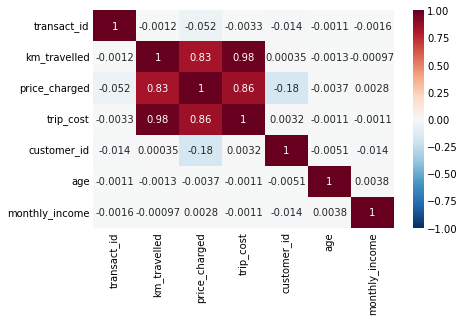

In [30]:
# Create a correlation matrix cab data using pearsonr
corr = cab_data.corr()
print(corr)


# Create a heatmap of the correlation matrix
sns.heatmap(corr,
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values,
            annot=True,
            cmap='RdBu_r',
            vmin=-1,
            vmax=1)
plt.show()

What we can determine from our measures and visuals from our Heatmap that distance or kilometers travelled is highly correlated with the cost of the trip and the price charged for the actual trip, and as such trip cost and price charged have a high level of correlation.

#### What is the overall relation between the price charged and the km travelled?

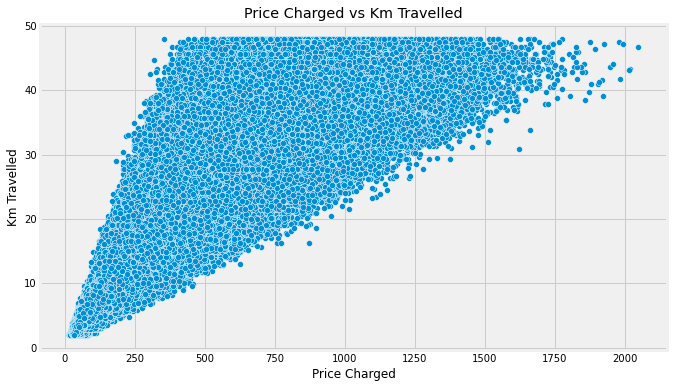

In [31]:
# What is the overall relation between the price charged and the km travelled?
def plot_price_charged_vs_km_travelled(cab_data):
    plt.figure(figsize=(10,6))
    sns.scatterplot(x=cab_data['price_charged'], y=cab_data['km_travelled'], data=cab_data, palette='Set2')
    plt.title('Price Charged vs Km Travelled')
    plt.xlabel('Price Charged')
    plt.ylabel('Km Travelled')
    plt.show()
    return


plot_price_charged_vs_km_travelled(cab_data)

In [32]:
#import plotly.graph_objects as go
#
#
## Create a scatter plot of the km travelled and price charged
#fig = go.Figure(data=go.Scatter(x=cab_data['km_travelled'],
#                                y=cab_data['price_charged'],
#                                mode='markers',
#                                marker=dict(size=10,
#                                            color=cab_data['company'],
#                                            colorscale='Viridis',
#                                            showscale=True)))
#fig.update_layout(title='KM Travelled vs Price Charged',
#                    xaxis_title='KM Travelled',
#                    yaxis_title='Price Charged')
#fig.show()

#### Is there a relationship between age and income?

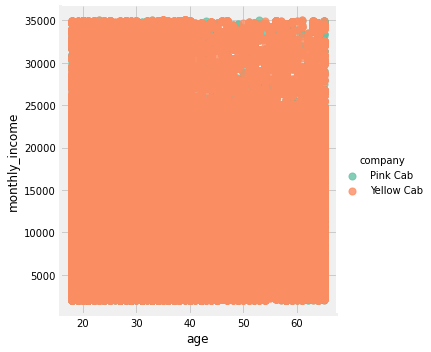

In [33]:
# Is there a relationship between age and income?
sns.lmplot(x='age',
              y='monthly_income',
                data=cab_data,
                fit_reg=False,
                hue='company',
                palette='Set2',
                scatter_kws={'s': 50})
plt.show()


#### What is the variance of price charged and trip cost?

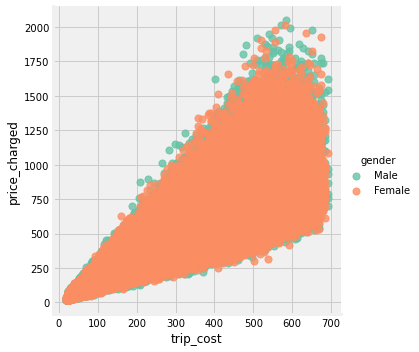

In [34]:
# What is the variance of price charged and trip cost?
sns.lmplot(x='trip_cost',
                y='price_charged',
                data=cab_data,
                fit_reg=False,
                hue='gender',
                palette='Set2',
                scatter_kws={'s': 50})
plt.show()

#### Relation between travel date and trip cost? 

In [35]:
# # Relation between travel date and trip cost?
#sns.lineplot(x=cab_data.index,
#                y='trip_cost',
#                data=cab_data,
#                hue='company',
#                palette='Set2')
#plt.show()
#

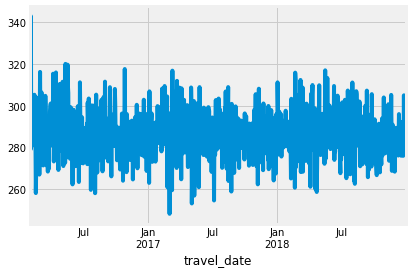

In [36]:
def get_mean(cab_data):
    return cab_data.resample('D').mean()

cab_data['travel_date'] = cab_data.index
date_range = pd.date_range(start='2016-01-31', end='2018-12-31')
mean_data = get_mean(cab_data['trip_cost'])

mean_data.plot()
plt.show()

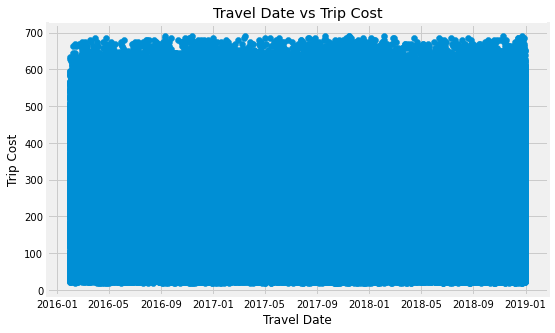

In [37]:
# Relation between travel date and trip cost?
def travel_date_vs_trip_cost():
    """
    Method:
        Plot the travel date vs trip cost
    """
    plt.figure(figsize=(8,5))
    plt.scatter(cab_data['travel_date'], cab_data['trip_cost'])
    plt.xlabel('Travel Date')
    plt.ylabel('Trip Cost')
    plt.title('Travel Date vs Trip Cost')
    plt.show()
    return

travel_date_vs_trip_cost()

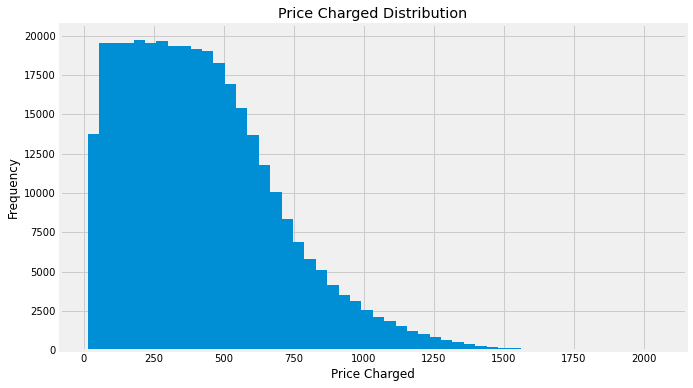

In [38]:
# Distribution of all features
def distribution_all():
    """
    Method:
        Distribution of all features
    """
    plt.figure(figsize=(10,6))
    plt.hist(cab_data['price_charged'], bins=50)
    plt.xlabel('Price Charged')
    plt.ylabel('Frequency')
    plt.title('Price Charged Distribution')
    plt.show()
    return


distribution_all()

In [39]:
city['Population'] = city['Population'].str.replace(',', '')

In [40]:
city['Users'] = city['Users'].str.replace(',', '')

Incorporate our City dataset to answer questions surrounding number of users in the city and the population of the ciites.

In [41]:
city['Population'] = city['Population'].astype(int)
city['Users'] = city['Users'].astype(int)
city.head()

,City,Population,Users
0,NEW YORK NY,8405837,302149
1,CHICAGO IL,1955130,164468
2,LOS ANGELES CA,1595037,144132
3,MIAMI FL,1339155,17675
4,SILICON VALLEY,1177609,27247


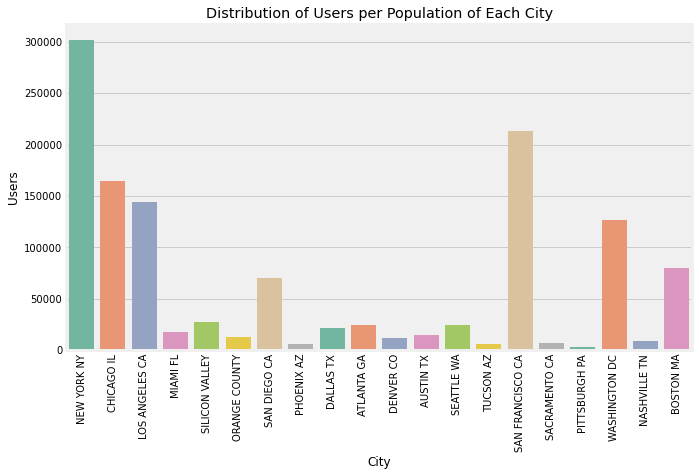

In [42]:
# Distribution of population per city
def distribution_population(city):
    """
    Method:
        Distribution of population per city
    
    Args:
        city: seaborn 
    """
    plt.figure(figsize=(10,6))
    sns.barplot(x='City', y='Users', data=city, palette='Set2')
    plt.title('Distribution of Users per Population of Each City')
    plt.xticks(rotation=90)
    plt.xlabel('City')
    plt.show()

distribution_population(city)

In [43]:
def get_percentage_users(city):
    """
    Method:
        Get the percentage of users per population of each city
    
    Args:
        city: pandas dataframe 
    """
    city['Percentage_Users'] = city['Users'] / city['Population'] * 100
    return city


city = get_percentage_users(city)
city

,City,Population,Users,Percentage_Users
0,NEW YORK NY,8405837,302149,3.594514
1,CHICAGO IL,1955130,164468,8.412126
2,LOS ANGELES CA,1595037,144132,9.036279
3,MIAMI FL,1339155,17675,1.319862
4,SILICON VALLEY,1177609,27247,2.313756
5,ORANGE COUNTY,1030185,12994,1.261327
6,SAN DIEGO CA,959307,69995,7.296413
7,PHOENIX AZ,943999,6133,0.649683
8,DALLAS TX,942908,22157,2.349858
9,ATLANTA GA,814885,24701,3.031225


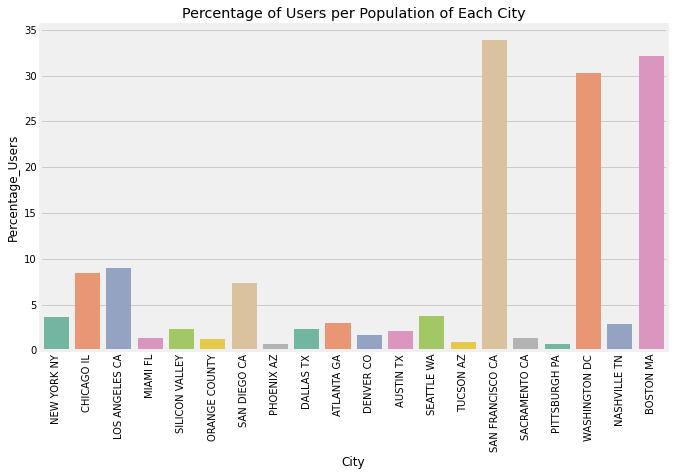

In [44]:
# Plot
def plot_percentage_users(city):
    """
    Method:
        Plot the percentage of users per population of each city
    
    Args:
        city: pandas dataframe 
    """
    plt.figure(figsize=(10,6))
    sns.barplot(x='City', y='Percentage_Users', data=city, palette='Set2')
    plt.title('Percentage of Users per Population of Each City')
    plt.xticks(rotation=90)
    plt.xlabel('City')
    plt.show()
    return


plot_percentage_users(city)

In [45]:
# Find total_cost and price_charged per company
total_cost = cab_data.groupby('price_charged').sum()
price_charged = cab_data.groupby('trip_cost').mean()

In [46]:
def get_profit_yellow(cab_yellow):

    cab_yellow['profit'] = cab_yellow['price_charged'] - cab_yellow['trip_cost']
    return cab_yellow

get_profit_yellow(cab_yellow)

,transact_id,company,city,km_travelled,price_charged,trip_cost,customer_id,payment_mode,gender,age,monthly_income,profit
travel_date,,,,,,,,,,,,
2018-08-19,10351127,Yellow Cab,ATLANTA GA,26.19,598.70,317.4228,29290,Cash,Male,28,10813,281.2772
2018-12-22,10412921,Yellow Cab,ATLANTA GA,42.55,792.05,597.4020,29290,Card,Male,28,10813,194.6480
2018-05-20,10320494,Yellow Cab,ATLANTA GA,36.38,721.10,467.1192,27703,Card,Male,27,9237,253.9808
2018-06-02,10324737,Yellow Cab,ATLANTA GA,6.18,138.40,87.5088,27703,Cash,Male,27,9237,50.8912
2016-10-20,10079404,Yellow Cab,ATLANTA GA,39.60,704.30,494.2080,28712,Card,Male,53,11242,210.0920
...,...,...,...,...,...,...,...,...,...,...,...,...
2018-02-05,10439790,Yellow Cab,SEATTLE WA,16.66,261.18,213.9144,38520,Card,Female,42,19417,47.2656
2018-02-01,10439799,Yellow Cab,SILICON VALLEY,13.72,277.97,172.8720,12490,Cash,Male,33,18713,105.0980
2018-02-02,10439838,Yellow Cab,TUCSON AZ,19.00,303.77,232.5600,41414,Card,Male,38,3960,71.2100


In [47]:
cab_yellow['profit'] = cab_yellow['price_charged'] - cab_yellow['trip_cost']
cab_pink['profit'] = cab_pink['price_charged'] - cab_pink['trip_cost']

In [48]:
cab_yellow

,transact_id,company,city,km_travelled,price_charged,trip_cost,customer_id,payment_mode,gender,age,monthly_income,profit
travel_date,,,,,,,,,,,,
2018-08-19,10351127,Yellow Cab,ATLANTA GA,26.19,598.70,317.4228,29290,Cash,Male,28,10813,281.2772
2018-12-22,10412921,Yellow Cab,ATLANTA GA,42.55,792.05,597.4020,29290,Card,Male,28,10813,194.6480
2018-05-20,10320494,Yellow Cab,ATLANTA GA,36.38,721.10,467.1192,27703,Card,Male,27,9237,253.9808
2018-06-02,10324737,Yellow Cab,ATLANTA GA,6.18,138.40,87.5088,27703,Cash,Male,27,9237,50.8912
2016-10-20,10079404,Yellow Cab,ATLANTA GA,39.60,704.30,494.2080,28712,Card,Male,53,11242,210.0920
...,...,...,...,...,...,...,...,...,...,...,...,...
2018-02-05,10439790,Yellow Cab,SEATTLE WA,16.66,261.18,213.9144,38520,Card,Female,42,19417,47.2656
2018-02-01,10439799,Yellow Cab,SILICON VALLEY,13.72,277.97,172.8720,12490,Cash,Male,33,18713,105.0980
2018-02-02,10439838,Yellow Cab,TUCSON AZ,19.00,303.77,232.5600,41414,Card,Male,38,3960,71.2100


In [49]:
cab_pink

,transact_id,company,city,km_travelled,price_charged,trip_cost,customer_id,payment_mode,gender,age,monthly_income,profit
travel_date,,,,,,,,,,,,
2016-02-06,10000011,Pink Cab,ATLANTA GA,30.45,370.95,313.635,29290,Card,Male,28,10813,57.315
2016-02-04,10000012,Pink Cab,ATLANTA GA,28.62,358.52,334.854,27703,Card,Male,27,9237,23.666
2018-11-25,10395626,Pink Cab,ATLANTA GA,13.39,167.03,141.934,27703,Card,Male,27,9237,25.096
2016-01-31,10000013,Pink Cab,ATLANTA GA,9.04,125.20,97.632,28712,Cash,Male,53,11242,27.568
2016-02-05,10000014,Pink Cab,ATLANTA GA,33.17,377.40,351.602,28020,Cash,Male,23,23327,25.798
...,...,...,...,...,...,...,...,...,...,...,...,...
2018-02-03,10437193,Pink Cab,SACRAMENTO CA,31.03,436.06,344.433,47760,Card,Male,47,8823,91.627
2018-01-31,10437278,Pink Cab,SAN DIEGO CA,26.73,343.83,304.722,18620,Card,Male,27,2876,39.108
2018-02-03,10437570,Pink Cab,SILICON VALLEY,22.23,386.13,264.537,14974,Cash,Male,51,8020,121.593


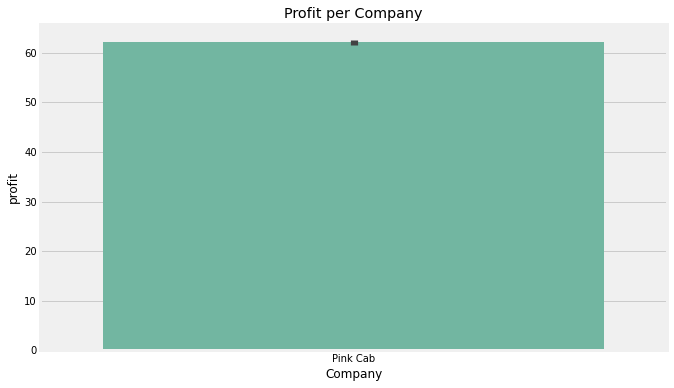

In [50]:
def plot_profit_per_company(cab_data):
    plt.figure(figsize=(10,6))
    sns.barplot(x=cab_pink['company'], y=cab_pink['profit'], data=cab_pink, palette='Set2')
    plt.title('Profit per Company')
    plt.xlabel('Company')
    plt.show()
    return


plot_profit_per_company(cab_data)

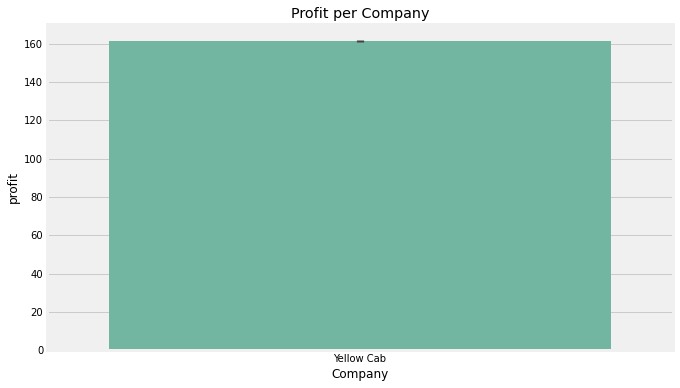

In [51]:
def plot_profit_per_company(cab_data):
    plt.figure(figsize=(10,6))
    sns.barplot(x=cab_yellow['company'], y=cab_yellow['profit'], data=cab_yellow, palette='Set2')
    plt.title('Profit per Company')
    plt.xlabel('Company')
    plt.show()
    return


plot_profit_per_company(cab_data)

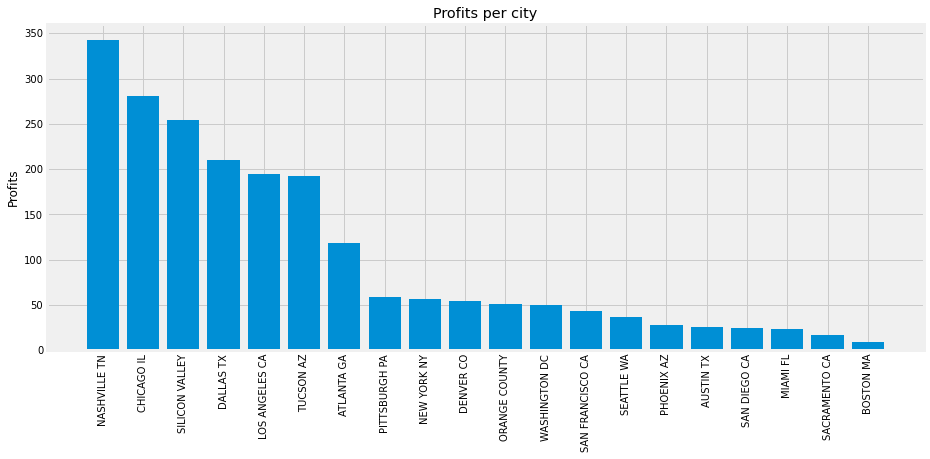

                  Profits
City                     
NASHVILLE TN        343.0
CHICAGO IL          281.0
SILICON VALLEY      254.0
DALLAS TX           210.0
LOS ANGELES CA      195.0
TUCSON AZ           192.0
ATLANTA GA          119.0
PITTSBURGH PA        59.0
NEW YORK NY          57.0
DENVER CO            54.0
ORANGE COUNTY        51.0
WASHINGTON DC        50.0
SAN FRANCISCO CA     43.0
SEATTLE WA           37.0
PHOENIX AZ           28.0
AUSTIN TX            26.0
SAN DIEGO CA         25.0
MIAMI FL             24.0
SACRAMENTO CA        17.0
BOSTON MA             9.0


In [52]:
price_charged = np.array(cab_data["price_charged"])
travel_cost = np.array(cab_data["trip_cost"])
profit = np.subtract(price_charged,travel_cost)
new = zip(city["City"],profit)
profit_df = (pd.DataFrame(new,columns = ["City","Profits"]).groupby("City").sum()).sort_values(by = "Profits",ascending=False)
new_df = profit_df.round()

plt.figure(figsize = (14,6))
plt.bar(new_df.index,new_df.Profits)
plt.xticks(rotation="90")
plt.ylabel("Profits")
plt.title("Profits per city")
plt.show()

print(new_df)

#### Cab Investment – G2M Strategy
***

**Conclusion**

- Number of **transactions** are seasonal, peaking around the first of the year for several periods. This would likely be due to colder weather reducing walking and increasing car issues.
- Average age of customer is `35` with standard deviation of `12`, so our **target audience** would be between `23-47`.
- Average Price Charged `$424.20`
- Average **KM Travelled** `22.6`
- Average **Trip Cost** `$286.2`
- There are `3.1` times as many transactions at **Yellow Cab** than **Pink Cab**
- The **cost of a trip** has a strong `high correlation` with km travelled
- **Price charged** is also `highly correlated` to km travelled and cost of trip
- **Profits** are `highest` in Nashville, Chicago, Silicon Valley, Dallas, with Los Angeles and Tucson being close for tying 5th.


**Recommendations**

In implementing our Go-to-market strategy the Data Science team recommends that financial investment would have a profitable ROI, from preliminary analysis. 

Further analysis using machine learning techniques, would be required to determine if the investment would be profitable over time such as time series prediction and some form of regression analysis.

